In [1]:
# a demonstration of use of the two-layered neural network classifier 
# for content classification on doc2vec docs vectors
# where softmax probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] https://deeplearning4j.org/welldressed-recommendation-engine
# [3] https://www.tensorflow.org/get_started/tflearn
# [4] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [3]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_categories=product_list,
                         vector_length=800, train_algo="dm")

# EITHER initialize the vocab of documents and minimize the distances of embeddings in training phase
# d2v_wrapper.init_model_vocab(content_basepath="../../data/content/playground/auto/nostem",
#                              basepath_suffix="_content.csv", drop_short_docs=10)
# d2v_wrapper.train_model(shuffle=True, epochs=1 if TEST_MODE else 5)
# d2v_wrapper.infer_vocab_content_vectors()

# d2v_wrapper.persist_trained_wrapper("trained_models/wrapper/5epoch_train_stem_not_removed_header_v800")

# OR load initialized and trained wrapper if available
d2v_wrapper.load_persisted_wrapper("trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_header")

2017-05-10 14:56:16,169 : INFO : Loading serialized wrapper model from: trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_header
2017-05-10 14:56:16,171 : INFO : Loading all_base_vocab_docs objects
2017-05-10 14:56:24,201 : INFO : Initialized 43478 headers of 43478 for vectorization
2017-05-10 14:56:24,202 : INFO : Loading all_base_vocab_docs vectors
2017-05-10 14:57:02,567 : INFO : Loading trained Doc2Vec model
2017-05-10 14:57:02,568 : INFO : loading Doc2Vec object from trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_headerdoc2vec.mod
2017-05-10 14:57:02,843 : INFO : loading docvecs recursively from trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_headerdoc2vec.mod.docvecs.* with mmap=None
2017-05-10 14:57:02,844 : INFO : loading doctag_syn0 from trained_models/wrapper/header_incl/10epoch_train_stem_not_removed_headerdoc2vec.mod.docvecs.doctag_syn0.npy with mmap=None
2017-05-10 14:57:03,098 : INFO : loading syn1neg from trained_model

In [4]:
# divide the docs data to vectors and targets
doc_vectors_labeled = d2v_wrapper.infer_vocab_content_vectors()
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

2017-05-10 14:57:03,545 : INFO : Returning already inferred doc vectors of 43478 all_base_vocab_docs


In [5]:
doc_vectors_labeled.head(10)

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,y
0,-0.261148,-0.143183,0.206254,0.002638,-0.136853,-0.184459,0.400641,-0.026630,0.055222,-0.507141,...,-0.002771,0.193008,-0.061081,0.116081,0.053434,0.050748,0.061903,-0.013674,-0.081310,amq
1,0.129629,0.330915,0.078725,0.343039,-0.164130,-0.322203,0.089643,-0.096555,-0.143530,0.177542,...,-0.036439,0.098115,-0.047751,0.191983,0.103851,-0.014857,0.147300,-0.048710,0.028055,amq
2,-0.122895,0.042616,0.311727,0.068287,-0.190215,-0.286972,-0.030751,-0.023960,-0.217911,0.005918,...,-0.034230,0.203534,0.057952,0.132727,0.011877,-0.031473,0.093483,-0.105260,-0.107189,amq
3,-0.081051,-0.112118,0.157368,0.018006,-0.024450,-0.293881,-0.078382,-0.241100,0.103017,0.140719,...,0.023935,0.223113,-0.047766,0.126704,0.071557,-0.091953,0.223931,-0.076425,0.104130,amq
4,-0.248997,-0.072568,0.270651,0.378066,0.100578,0.104005,0.063351,0.003771,0.149455,0.300134,...,0.020857,0.122567,0.028789,0.043602,-0.046213,-0.016964,0.118787,-0.025481,-0.185460,amq
5,0.132138,-0.070874,0.411625,-0.073018,-0.201902,0.128727,-0.243356,-0.355984,0.040756,-0.311196,...,-0.045529,0.303851,0.028779,0.072786,-0.054523,-0.022502,0.141018,-0.041490,0.015366,amq
6,0.415581,0.094154,0.334570,-0.033714,0.001877,-0.015157,0.087919,-0.355922,0.082679,0.082770,...,-0.023633,0.257899,0.042370,0.109216,0.000828,-0.008879,0.222199,-0.005134,-0.033780,amq
7,0.672777,-0.549360,0.014788,0.015485,-0.034586,-0.177955,-0.117172,-0.534560,-0.230965,-0.185388,...,-0.071189,0.291642,-0.042231,0.106547,-0.054053,-0.031451,0.192578,-0.021674,-0.050568,amq
8,-0.231420,0.146912,0.162502,0.121931,-0.277280,-0.140563,0.052438,-0.346920,0.122520,0.111098,...,0.000184,0.000794,-0.000187,0.000104,-0.000457,-0.000089,-0.000197,-0.000503,0.000012,amq
9,0.087633,0.331549,0.233062,-0.045076,-0.174967,-0.079236,0.206668,-0.217895,-0.059720,-0.198520,...,0.000184,0.000794,-0.000187,0.000104,-0.000457,-0.000089,-0.000197,-0.000503,0.000012,amq


In [6]:
doc_labels.describe()

count     43478
unique       14
top         eap
freq      18302
Name: y, dtype: object

In [7]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [8]:
# encoding/decoding target categories
mapping = []


def encode_categories(target_series):
    global mapping
    if not len(mapping):
        for cat in target_series.unique():
            mapping.append(cat)

    return target_series.apply(lambda cat_str: mapping.index(cat_str))


def decode_categories(target_series):
    global mapping
    return target_series.apply(lambda cat_idx: mapping[cat_idx])

In [9]:
# transforms the given content to Tensorflow format
def dataset_from_dataframe(data_df, target_series):
    dataset = tf.contrib.learn.datasets.base.Dataset(data=data_df.values, target=encode_categories(target_series))
    return dataset

In [ ]:
# classifier training and eval:
accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=2 if TEST_MODE else 5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):
    
    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)
    
    train_vectors = doc_vectors.iloc[train_doc_indices]

    y_true = doc_labels.iloc[train_doc_indices]

    tf_dataset = dataset_from_dataframe(train_vectors, y_true)
    
    # columns are initialized as Tensors
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=doc_vectors.shape[1])]
    
    # init model:
    # model consists of two layers as described in [2]
    # 1. dense, fully-connected layer with relu act. function
    # 2. softmax output layer for classification and further relevance scoring
    two_layer_nn_classifier = SKCompat(tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                                                  hidden_units=[doc_vectors.shape[1] / 2],
                                                                  activation_fn=tf.nn.relu,
                                                                  dropout=0.05,
                                                                  n_classes=len(d2v_wrapper.content_categories),
                                                                  optimizer="Adam"))

    two_layer_nn_classifier.fit(x=tf_dataset.data,
                                y=tf_dataset.target,
                                steps=500 if TEST_MODE else 4000)

    # testing
    # can be used to infer the relative relevance (or score) of the document for categories    
    nn_logits = two_layer_nn_classifier.predict(doc_vectors.iloc[test_doc_indices].values)
    
    y_actual = decode_categories(pd.Series(nn_logits["classes"])).values
    y_expected = doc_labels.iloc[test_doc_indices].values

    # evaluation:
    # logits
    actual_prob = nn_logits["probabilities"][np.arange(len(nn_logits["probabilities"])),(nn_logits["classes"])]
    expected_prob = nn_logits["probabilities"][np.arange(len(nn_logits["probabilities"])),(encode_categories(pd.Series(y_expected)))]
    new_logits = pd.DataFrame()
    new_logits["doc_id"] = test_doc_indices
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    logits = logits.append(new_logits)
    
    # accuracy
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.warn("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.warn("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))

In [11]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-05-10 15:01:53,722 : INFO : split accuracies: [0.83406113537117899, 0.83595815610989765, 0.81564117308798156, 0.83513575701794751, 0.83302646720368234]
2017-05-10 15:01:53,723 : INFO : mean accuracy: 0.830764537758
2017-05-10 15:01:53,731 : INFO : categories accuracies: 
        amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.396947  0.947282   0.177083  0.476190  0.792505  0.477941  0.217778   
0  0.335878  0.925977   0.366492  0.349206  0.807772  0.400735  0.471111   
0  0.442748  0.879781   0.455497  0.349206  0.780708  0.488971  0.320000   
0  0.259542  0.956831   0.104712  0.349206  0.825815  0.284133  0.544643   
0  0.315385  0.919126   0.387435  0.403226  0.843858  0.258303  0.482143   

   devstudio  cdk  developertoolset      rhel  softwarecollections  \
0   0.819259  0.0               0.0  0.899463                  0.0   
0   0.761481  0.0               0.0  0.930108                  0.0   
0   0.798519  0.0               0.0  0.930876           

In [12]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,5
9,developertoolset,0.000000,12
8,cdk,0.000000,72
12,mobileplatform,0.200000,101
3,datagrid,0.385407,314
0,amq,0.350100,654
2,webserver,0.298244,956
6,bpmsuite,0.407135,1123
5,brms,0.382016,1358
7,devstudio,0.789798,3373


In [13]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
# expected_* marks the real category and its probability estimated by the model, 
# whereas actual_* marks the selected category (=mostly probable) by the model 
logits.head(25)

,actual_class,actual_prob,doc_id,expected_class,expected_prob
0,datagrid,0.999954,9074.0,eap,0.000046
1,eap,0.971189,6627.0,eap,0.971189
2,eap,0.944539,21986.0,fuse,0.054448
3,eap,0.999995,16702.0,eap,0.999995
4,eap,0.306552,33325.0,cdk,0.018764
5,brms,0.985327,29276.0,bpmsuite,0.014353
6,eap,0.999848,11030.0,eap,0.999848
7,devstudio,0.890113,30313.0,devstudio,0.890113
8,eap,0.910324,13073.0,eap,0.910324
9,devstudio,0.972970,29946.0,devstudio,0.972970


In [14]:
# only missclassifications:
logits[logits["expected_class"] != logits["actual_class"]].head(25)

,actual_class,actual_prob,doc_id,expected_class,expected_prob
0,datagrid,0.999954,9074.0,eap,4.622334e-05
2,eap,0.944539,21986.0,fuse,5.444783e-02
4,eap,0.306552,33325.0,cdk,1.876356e-02
5,brms,0.985327,29276.0,bpmsuite,1.435343e-02
12,eap,0.416150,42696.0,openshift,7.894972e-03
24,rhel,0.797404,19564.0,webserver,1.504637e-01
27,eap,1.000000,21541.0,fuse,1.802928e-08
28,eap,0.341828,39387.0,rhel,8.181401e-02
30,eap,0.306552,29906.0,bpmsuite,3.480759e-02
32,eap,0.306552,29651.0,bpmsuite,3.480759e-02


In [15]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = logits[logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['eap', 'fuse', 'devstudio', 'rhel', 'openshift', 'brms'], dtype=object)

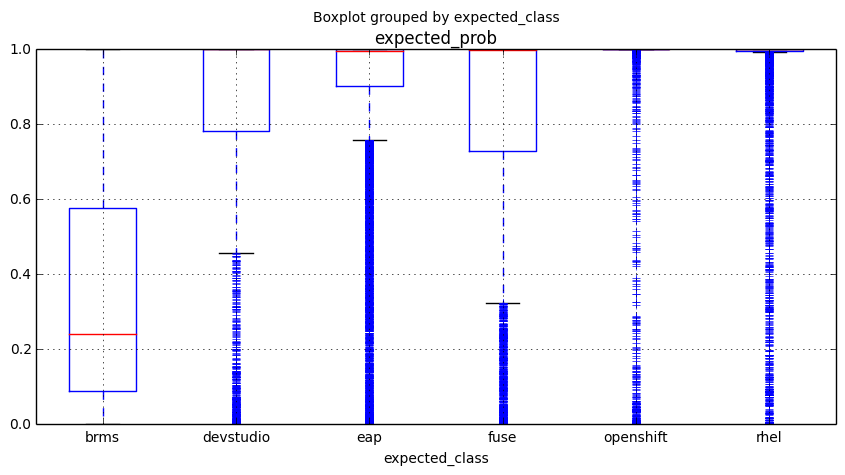

In [16]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,5))

In [17]:
# incorrect classification characteristics
wrong_docs_ids = logits[logits["expected_class"] != logits["actual_class"]]["doc_id"]

wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.get_doc_content(int(doc_id), word_split=True))
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))
wrong_docs_len.describe()

count     7358.000000
mean       128.483963
std        392.548295
min         10.000000
25%         19.000000
50%         33.000000
75%         76.000000
max      12476.000000
Name: doc_id, dtype: float64

In [18]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(doc_vectors)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
# data need to be indexed incrementally for later plotting
correct_docs.index=np.arange(len(correct_docs))
correct_docs_wordlist = correct_docs.apply(lambda doc_id: d2v_wrapper.get_doc_content(doc_id, word_split=True))
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count    36120.000000
mean       139.157254
std        640.824510
min         10.000000
25%         26.000000
50%         41.000000
75%        105.000000
max      79212.000000
dtype: float64

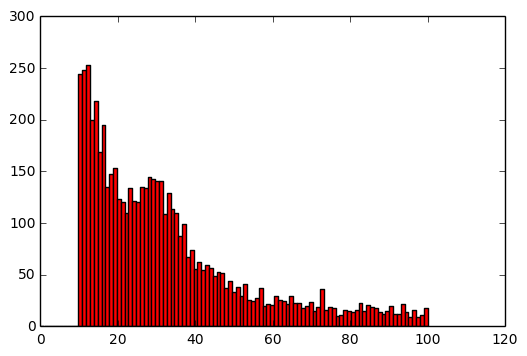

In [19]:
# missclassified docs length distribution
bordering_q = 0.8
bordering_q_value = int(wrong_docs_len.quantile(q=bordering_q))
plt.hist(wrong_docs_len.values, bins=bordering_q_value+1, range=(0, bordering_q_value), color="r")
plt.show()

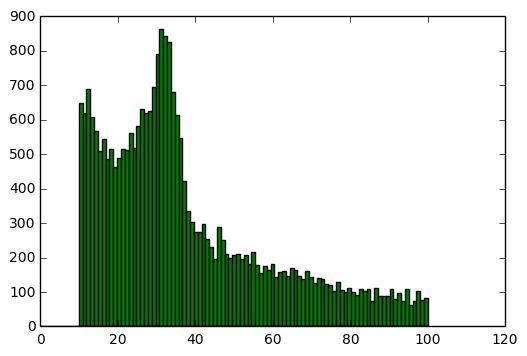

In [20]:
# correctly classified length distribution
plt.hist(correct_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="g")
plt.show()

<Container object of 100 artists>

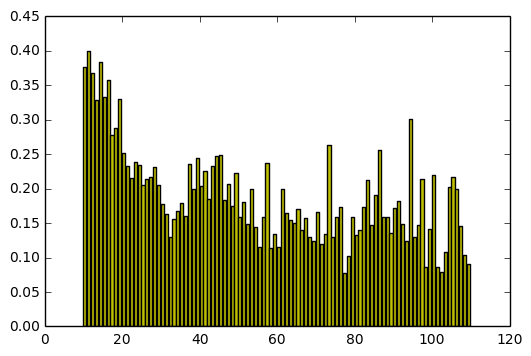

In [21]:
# distribution of incorrectly/correctly classified ratio by docs length
doc_len_error = (wrong_docs_len.value_counts() / correct_docs_len.value_counts())
ploted_doc_len_error = doc_len_error[:bordering_q_value]

plt.bar(ploted_doc_len_error.index, ploted_doc_len_error, color="y")

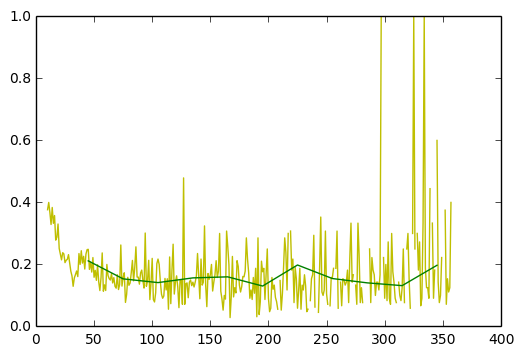

In [22]:
error_plot_border = 350
error_ploted = doc_len_error[:error_plot_border]
plt.plot(error_ploted.index, error_ploted, color="y")

mean_range = 30
mean_plot_ids = range(mean_range, error_plot_border+mean_range, mean_range)
mean_plot_vals = map(lambda mean_id: error_ploted.iloc[mean_id-5-mean_range: mean_id+5-mean_range].mean(), mean_plot_ids)
mean_plot = pd.Series(mean_plot_vals)
mean_plot.index = np.array(mean_plot_ids)-mean_range/2
plt.plot(mean_plot.index , mean_plot, color="g")

In [23]:
# docs get associated with its content
logits["content_len"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                len(d2v_wrapper.get_doc_content(int(doc_id), word_split=True))).values
logits["content"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                d2v_wrapper.get_doc_content(int(doc_id), word_split=False)).values

In [24]:
# assign the textual content to classification logits so we can easily analyze that
logits["content_len"] = logits["doc_id"].apply(lambda doc_id: 
                                               len(d2v_wrapper.get_doc_content(int(doc_id), word_split=True)))
logits["content"] = logits["doc_id"].apply(lambda doc_id: 
                                           d2v_wrapper.get_doc_content(int(doc_id), word_split=False)[:100])

In [33]:
# a random sample of missclassified document
wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.get_doc_content(int(doc_id), word_split=False))[120:125].tolist()

['configure jboss activemq openshift source image feature https docs openshift com enterprise images xpaas images html configuring sti.',
 'like remotely save content task method rest api way business process console user save content task methos rest api.',
 'created new jboss esb project based version esb try add project server deployment add remove shows following error server support version jboss esb module specification.',
 'tim hildred products technologies team brisbane australia recently published great summary history containerization check history containers red hat enterprise linux containers blog post history containers.',
 'jmx browse return maxbrowsesize browse attempt maxbrowsesize affect browse attempt default value behavior observed jmx api access broker.']